In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import scipy.io as sio

## odour landscape

In [7]:
from gaussian_plume_model import get_odour_conc_landscape, get_odour_concentration

x = np.linspace(-10, 10, 100)
y = np.linspace(-5, 5, 100)
mesh_x, mesh_y = np.meshgrid(x, y)
c = np.zeros([len(x),len(y)])
for i, xi in enumerate(x):
    for j, yi in enumerate(y):
        c[i][j] = get_odour_conc_landscape(xi, yi, 10.0, [None, 1.0], k=20.0, tau=1, shape='bar')

In [22]:
get_odour_conc_landscape(0, 2, 1.0, [None, 1.0], k=20.0, tau=1, shape='bar')

12.130613194252668

In [21]:
get_odour_conc_landscape(2, 2, 1.0, [None, 1.0], k=20.0, tau=1, shape='bar')

12.130613194252668

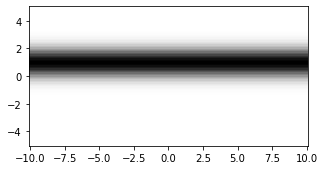

In [11]:
fig, ax = plt.subplots(figsize=(5,10))
ax.pcolormesh(mesh_x, mesh_y, c.T, cmap='gray_r', vmax=np.max(c), vmin=np.min(c), shading='auto')
ax.set_aspect(1)

## chemotaxis

In [53]:
from odor_wind_navigation import OdourWindNavigationFly

# odour source param
sx = 0
sy = 0
q = 10
# no wind
u = 0
w_dir = 0

radius = 4

OwN_fly = OdourWindNavigationFly(q, u, w_dir, radius, sx, sy, shape='Well')

In [55]:
x = np.linspace(-15, 15, 60)
y = np.linspace(-15, 15, 60)
mesh_x, mesh_y = np.meshgrid(x, y)
c = np.zeros([len(x),len(y)])
for i, xi in enumerate(x):
    for j, yi in enumerate(y):
        c[i][j] = OwN_fly.odour_field.get_odour_concentration(xi, yi)

In [56]:
# run a trial
start_pos = [10,0]
start_h = np.pi/2

time_out = 1200

step_size = 0.02
motor_k = 1.0

wind_direction = -np.pi/2 * np.ones(time_out)

# generate odour dynamics
odour_on_period = [0,time_out]
odour_input = np.zeros(time_out)
odour_input[odour_on_period[0]:odour_on_period[1]] = 1.0

# arena boundary
arena_boundary = [-15, 15, -15, 15]

OwN_fly.odour_on_thr = 0.01
pos, h, v, odor, dis, t = OwN_fly.run(start_pos, start_h, time_out,
                               odour_input, wind_direction, strategy='odour_homing', oh_k=5e3,
                               step_size=step_size, motor_k=motor_k, stop_by_source=False, boundary=arena_boundary)

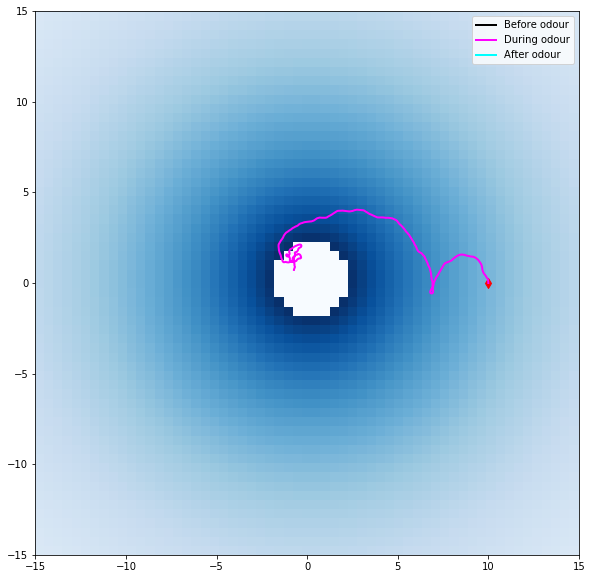

In [57]:
fig,ax=plt.subplots(figsize=(10,10))
# odour concentration
ax.pcolormesh(mesh_x, mesh_y,c, cmap='Blues')
# trajectory
ax.plot(pos[:odour_on_period[0],0],pos[:odour_on_period[0],1],c='k',lw=2, label='Before odour')
ax.plot(pos[odour_on_period[0]:odour_on_period[1],0],pos[odour_on_period[0]:odour_on_period[1],1],c='magenta',lw=2,label='During odour')
ax.plot(pos[odour_on_period[1]:,0],pos[odour_on_period[1]:,1],c='cyan',lw=2, label='After odour')

# start point
ax.scatter(start_pos[0],start_pos[1],c='red',s=50,marker='d')
# wind direction
# ax.quiver(1,12,np.cos(-np.pi/2),np.sin(-np.pi/2),width=0.05,scale=2.5)
# ax.text(-10,13,'wind direction',fontsize=15)
# ax.set_xlim(-21,21)
# ax.set_ylim(-141,20)
ax.set_aspect(1)
# ax.grid(1)
# ax.legend()

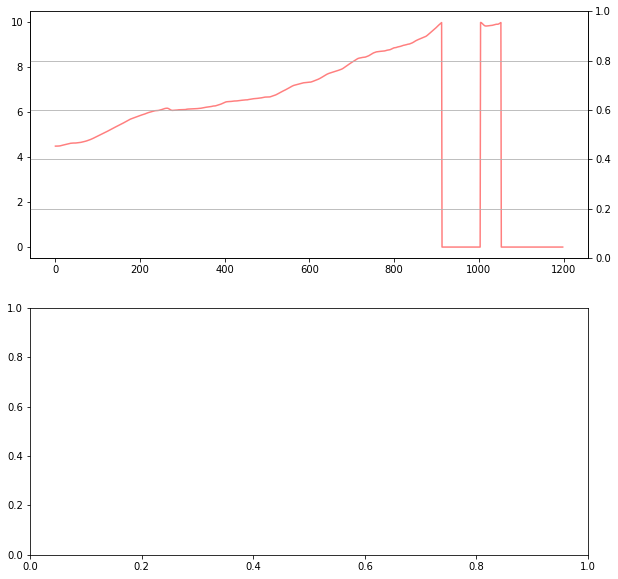

In [58]:
# plot the odor sense
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(odor[:-1], lw=1.5, c='red', alpha=0.5, label='C')
ax_w = ax[0].twinx()
# ax_w.plot(delta_odour, lw=1.5, c='blue', alpha=0.5, label='')
# ax[0].grid(1)
ax_w.grid(1)

# ax1_w = ax[1].twinx()
# ax[1].plot(np.roll(h[1:],1) - h[1:], c='k', alpha=0.5)
# ax1_w.plot(delta_odour, lw=1.5, c='blue', alpha=0.5, label='')    

# ax[0].quiver(odour_on_period[0], max(odor)*1.1, 0, -1)
# ax[0].quiver(odour_on_period[1], max(odor)*1.1, 0, -1)

In [68]:
# run serials of trials
from odor_wind_navigation import OdourWindNavigationFly
# odour source param
sx = 0
sy = 0
q = 10
# no wind
u = 0
w_dir = 0

radius = 6
agent_num = 5
# create agent
agents = list([OdourWindNavigationFly(q, u, w_dir, radius, sx, sy, shape='Volcano', handedness=i%2) for i in range(agent_num)])

# get the odour distribution
x = np.linspace(-15, 15, 120)
y = np.linspace(-15, 15, 120)
mesh_x, mesh_y = np.meshgrid(x, y)
mesh_c = np.zeros([len(x),len(y)])
for i, xi in enumerate(x):
    for j, yi in enumerate(y):
        mesh_c[i][j] = agents[0].odour_field.get_odour_concentration(xi, yi)
        
trial_num = 4

time_out = 1500
step_size = 0.02
motor_k = 1.0

wind_direction = -np.pi/2 * np.ones(time_out)

# store the data
pos_s = []
h_s = []
odor_s = []
dis_s = []
t_s = []

# generate odour dynamics
odour_on_period = [0, time_out]
odour_input = np.zeros(time_out)
odour_input[odour_on_period[0]:odour_on_period[1]] = 1.0

# arena boundary
arena_boundary = [-15, 15, -15, 15]

for i, agent in enumerate(agents):
    for trial in range(trial_num):
        print('%dth agent - %dth trial -> %s:' % (i, trial, 'odour_homing'))
        # x in [-15,15], y in [-15, 15]
        start_pos = [24.0*(np.random.rand(1)-0.5), 24.0*(np.random.rand(1)-0.5)]
        start_h = np.random.rand(1)*np.pi*2
        pos, h, v, odor, dis, t = agent.run(start_pos, start_h, time_out,
                                            odour_input, wind_direction, strategy='odour_homing', oh_k=1e2,
                                            step_size=step_size, motor_k=motor_k, stop_by_source=False, boundary=arena_boundary)
        pos_s.append(pos)
        h_s.append(h)
        odor_s.append(odor)
        dis_s.append(dis)
        t_s.append(t)

0th agent - 0th trial -> odour_homing:
0th agent - 1th trial -> odour_homing:
0th agent - 2th trial -> odour_homing:
0th agent - 3th trial -> odour_homing:
1th agent - 0th trial -> odour_homing:
1th agent - 1th trial -> odour_homing:
1th agent - 2th trial -> odour_homing:
1th agent - 3th trial -> odour_homing:
2th agent - 0th trial -> odour_homing:
2th agent - 1th trial -> odour_homing:
2th agent - 2th trial -> odour_homing:
2th agent - 3th trial -> odour_homing:
3th agent - 0th trial -> odour_homing:
3th agent - 1th trial -> odour_homing:
3th agent - 2th trial -> odour_homing:
3th agent - 3th trial -> odour_homing:
4th agent - 0th trial -> odour_homing:
4th agent - 1th trial -> odour_homing:
4th agent - 2th trial -> odour_homing:
4th agent - 3th trial -> odour_homing:


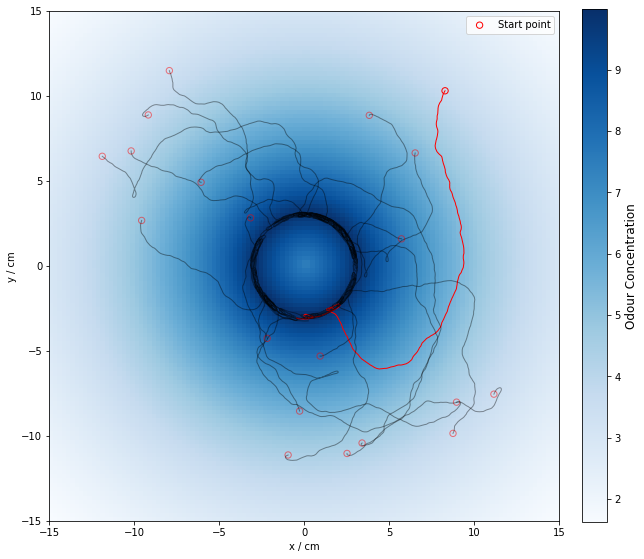

In [69]:
# plot result
fig, ax = plt.subplots(figsize=(10,10))

# odour concentration
heatmap = ax.pcolormesh(mesh_x, mesh_y, mesh_c, cmap='Blues')

selected_id = 10

pos = pos_s[selected_id]
 # start point
ax.scatter(pos[0,0],pos[0,1], s=40, marker='o', c='', edgecolor='r', label='Start point')
ax.plot(pos[:,0],pos[:,1], c='r',lw=1.0)


for i, pos in enumerate(pos_s):
    if i!=selected_id:
        # start point
        ax.scatter(pos[0,0],pos[0,1],s=40, marker='o', c='', edgecolor='r', alpha=0.5)
        # trajectory
        ax.plot(pos[:,0],pos[:,1], c='k',lw=1.0, alpha=0.4)

# add colorar
colorbar = fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
colorbar.set_label('Odour Concentration', fontsize=12)

ax.set_xlim(-15,15)
ax.set_ylim(-15,15)
ax.set_xlabel('x / cm')
ax.set_ylabel('y / cm')
ax.set_aspect(1)

ax.legend()

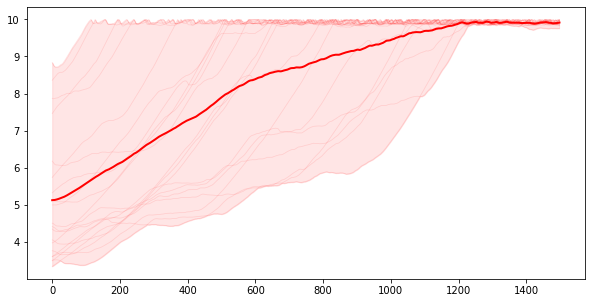

In [70]:
# plot result
fig, ax = plt.subplots(figsize=(10,5))

# ax.plot(odor_s[selected_id][:-1])
for i, odor_c in enumerate(odor_s):
    ax.plot(odor_c[:-1], c='red', alpha=0.1, lw=0.8)

ax.plot(np.mean(np.array(odor_s)[:,:-1], axis=0), color='red',lw=2)
ax.fill_between(np.arange(0,min(t_s)), np.max(np.array(odor_s)[:,:min(t_s)], axis=0), np.min(np.array(odor_s)[:,:min(t_s)], axis=0),
                  color='r', alpha=0.1)


In [71]:
# save the simulational data
sio.savemat('results/chemotaxis_Volcano.mat',{'pos':pos_s, 'h':h_s, 'odor':odor_s, 'dis':dis_s, 
                                             'mesh_x':mesh_x, 'mesh_y':mesh_y, 'mesh_c':mesh_c})

## wind direction encoding

In [29]:
from insect_brain_model import WindDirectionEncoder
wind_encoder = WindDirectionEncoder()

heading = [0, np.pi/2]

wind_direction = np.linspace(-np.pi, 0, 60)

apn = [[] for i in range(len(heading))]
b1 = [[] for i in range(len(heading))]
wpn = [[] for i in range(len(heading))]

for i, h in enumerate(heading):
    for wr in wind_direction:
        wpn[i].append(wind_encoder.upwind_activation(h, wr))
        apn[i].append(wind_encoder.apn)
        b1[i].append(wind_encoder.b1)

In [31]:
sio.savemat('results/wind_direction_encoding.mat', {'heading':heading, 'wind_dir':wind_direction,'apn':apn, 'b1':b1, 'wpn':wpn})

## odour gated anemotaxis

In [3]:
from odor_wind_navigation import OdourWindNavigationFly

# odour source param
sx = 0
sy = 0
q = 10
# with wind
u = 10
w_dir = -np.pi/2

radius = 4

OwN_fly = OdourWindNavigationFly(q, u, w_dir, radius, sx, sy)

In [4]:
x = np.linspace(-20, 20, 40)
y = np.linspace(-140, 0, 140)
mesh_x, mesh_y = np.meshgrid(x, y)
mesh_x, mesh_y = np.meshgrid(x, y)
mesh_c = OwN_fly.odour_field.get_odour_concentration(mesh_x, mesh_y)

In [25]:
### run serials of trials
from odor_wind_navigation import OdourWindNavigationFly
# odour source param
sx = 0
sy = 0
q = 10
# no wind
u = 10
w_dir = 0

radius = 6
agent_num = 4
# create agent
agents = list([OdourWindNavigationFly(q, u, w_dir, radius, sx, sy, handedness=i%2) for i in range(agent_num)])
        
trial_num = 5

time_out = 200
step_size = 0.4
motor_k = 1.5

wind_direction = -np.pi/2 * np.ones(time_out)

# store the data
pos_s = []
h_s = []
odor_s = []
dis_s = []
t_s = []
v_s = []
# generate odour dynamics
odour_on_period = [int(time_out/4), int(time_out/2)]
odour_input = np.zeros(time_out)
odour_input[odour_on_period[0]:odour_on_period[1]] = 1.0

# arena boundary
arena_boundary = [-20, 20, -140, 0]

for i, agent in enumerate(agents):
    for trial in range(trial_num):
        print('%dth agent - %dth trial -> %s:' % (i, trial, 'odour_gated_upwind'))
        agent.odour_on_thr = 0.01
        # x in [-15,15], y in []
        start_pos = [30.0*(np.random.rand(1)-0.5), np.random.rand(1)*80.0 - 130.0]
        start_h = np.random.rand(1)*np.pi*2
        pos, h, v, odor, dis, t = agent.run(start_pos, start_h, time_out,
                                            odour_input, wind_direction, strategy='odour_gated_upwind', oh_k=1e2,
                                            step_size=step_size, motor_k=motor_k, stop_by_source=False, boundary=arena_boundary)
        pos_s.append(pos)
        v_s.append(v)
        h_s.append(h)
        odor_s.append(odor)
        dis_s.append(dis)
        t_s.append(t)

0th agent - 0th trial -> odour_gated_upwind:
0th agent - 1th trial -> odour_gated_upwind:
0th agent - 2th trial -> odour_gated_upwind:
0th agent - 3th trial -> odour_gated_upwind:
0th agent - 4th trial -> odour_gated_upwind:
1th agent - 0th trial -> odour_gated_upwind:
1th agent - 1th trial -> odour_gated_upwind:
1th agent - 2th trial -> odour_gated_upwind:
1th agent - 3th trial -> odour_gated_upwind:
1th agent - 4th trial -> odour_gated_upwind:
2th agent - 0th trial -> odour_gated_upwind:
2th agent - 1th trial -> odour_gated_upwind:
2th agent - 2th trial -> odour_gated_upwind:
2th agent - 3th trial -> odour_gated_upwind:
2th agent - 4th trial -> odour_gated_upwind:
3th agent - 0th trial -> odour_gated_upwind:
3th agent - 1th trial -> odour_gated_upwind:
3th agent - 2th trial -> odour_gated_upwind:
3th agent - 3th trial -> odour_gated_upwind:
3th agent - 4th trial -> odour_gated_upwind:


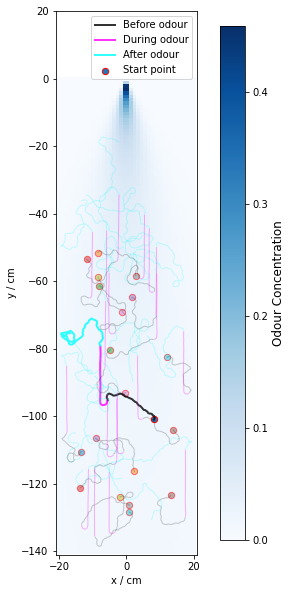

In [27]:
# plot result
fig, ax = plt.subplots(figsize=(10,10))

# odour concentration
heatmap = ax.pcolormesh(mesh_x, mesh_y, mesh_c, cmap='Blues', shading='auto')

selected_id = 1

pos = pos_s[selected_id]
 # start point
ax.scatter(pos[0,0],pos[0,1], s=40, marker='o', c=None, edgecolor='red', label='Start point')
ax.plot(pos[:odour_on_period[0],0],pos[:odour_on_period[0],1],c='black',lw=2.0, alpha=0.8, label='Before odour')
ax.plot(pos[odour_on_period[0]:odour_on_period[1],0],pos[odour_on_period[0]:odour_on_period[1],1],
        alpha=0.8, c='magenta',lw=2.0,label='During odour')
ax.plot(pos[odour_on_period[1]:,0],pos[odour_on_period[1]:,1],
        alpha=0.8, c='cyan',lw=2.0, label='After odour')


for i, pos in enumerate(pos_s):
    if i!=selected_id:
        # start point
        ax.scatter(pos[0,0],pos[0,1],s=40, marker='o', c=None, edgecolor='red', alpha=0.5)
        # trajectory
        ax.plot(pos[:odour_on_period[0],0],pos[:odour_on_period[0],1],c='black',lw=1.0, alpha=0.2)
        ax.plot(pos[odour_on_period[0]:odour_on_period[1],0],pos[odour_on_period[0]:odour_on_period[1],1],
                alpha=0.3, c='magenta',lw=1.0)
        ax.plot(pos[odour_on_period[1]:,0],pos[odour_on_period[1]:,1],
                alpha=0.2, c='cyan',lw=1.0)

# add colorar
colorbar = fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
colorbar.set_label('Odour Concentration', fontsize=12)


ax.set_xlim(-21,21)
ax.set_ylim(-141,20)
ax.set_xlabel('x / cm')
ax.set_ylabel('y / cm')
ax.set_aspect(1)

ax.legend()

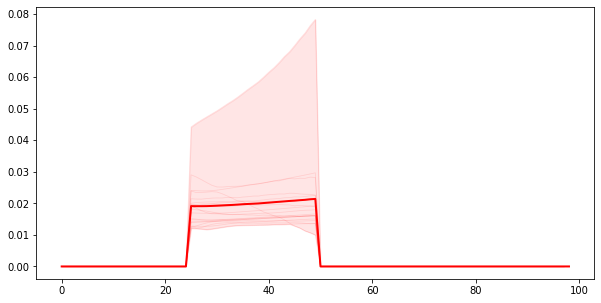

In [18]:
# plot result
fig, ax = plt.subplots(figsize=(10,5))

# ax.plot(odor_s[selected_id][:-1])
for i, odor_c in enumerate(odor_s):
    ax.plot(odor_c[:-1], c='red', alpha=0.1, lw=0.8)

ax.plot(np.mean(np.array(odor_s)[:,:-1], axis=0), color='red',lw=2)
ax.fill_between(np.arange(0,min(t_s)), np.max(np.array(odor_s)[:,:min(t_s)], axis=0), np.min(np.array(odor_s)[:,:min(t_s)], axis=0),
                  color='r', alpha=0.1)

In [26]:
sio.savemat('results/anemotaxis.mat',{'pos':pos_s, 'h':h_s, 'v':v_s, 'odor':odor_s, 'dis':dis_s, 't_s':t_s,
                                      'mesh_x':mesh_x, 'mesh_y':mesh_y, 'mesh_c':mesh_c, 
                                      'odour_daynamics': odour_on_period, 'odour_input':odour_input,
                                      'step_size':step_size, 'motor_k':motor_k, 'time_out':time_out})

## ON and OFF response for contextual integration

In [3]:
from odor_wind_navigation import OdourWindNavigationFly

# odour source param
sx = 0
sy = 0
q = 10
# with wind
u = 10
w_dir = -np.pi/2

radius = 4

OwN_fly = OdourWindNavigationFly(q, u, w_dir, radius, sx, sy)

SyntaxError: invalid character in identifier (odor_wind_navigation.py, line 285)

In [67]:
x = np.linspace(-20, 20, 40)
y = np.linspace(-140, 0, 140)
mesh_x, mesh_y = np.meshgrid(x, y)
mesh_x, mesh_y = np.meshgrid(x, y)
mesh_c = OwN_fly.odour_field.get_odour_concentration(mesh_x, mesh_y)

In [68]:
### run serials of trials
from odor_wind_navigation import OdourWindNavigationFly
# odour source param
sx = 0
sy = 0
q = 10

u = 10
w_dir = 0

radius = 6
agent_num = 4
# create agent
agents = list([OdourWindNavigationFly(q, u, w_dir, radius, sx, sy, handedness=i%2) for i in range(agent_num)])
        
trial_num = 5

time_out = 200
step_size = 0.4
motor_k = 1.5

wind_direction = -np.pi/2 * np.ones(time_out)

# store the data
pos_s = []
h_s = []
odor_s = []
dis_s = []
t_s = []
v_s = []
response_state = []
# generate odour dynamics
odour_on_period = [int(time_out/4), int(time_out/2)]
odour_input = np.zeros(time_out)
odour_input[odour_on_period[0]:odour_on_period[1]] = 1.0

# arena boundary
arena_boundary = [-20, 20, -140, 0]

for i, agent in enumerate(agents):
    for trial in range(trial_num):
        print('%dth agent - %dth trial -> %s:' % (i, trial, 'integrated'))
        agent.odour_on_thr = 0.01
        # x in [-15,15], y in []
        start_pos = [30.0*(np.random.rand(1)-0.5), np.random.rand(1)*80.0 - 130.0]
        start_h = np.random.rand(1)*np.pi*2
        pos, h, v, odor, dis, t = agent.run(start_pos, start_h, time_out,
                                            odour_input, wind_direction, strategy='integrated', oh_k=1e2,
                                            step_size=step_size, motor_k=motor_k, stop_by_source=False, boundary=arena_boundary)
        pos_s.append(pos)
        v_s.append(v)
        h_s.append(h)
        odor_s.append(odor)
        dis_s.append(dis)
        t_s.append(t)
        response_state.append(agent.response_state)

0th agent - 0th trial -> integrated:
0th agent - 1th trial -> integrated:
0th agent - 2th trial -> integrated:
0th agent - 3th trial -> integrated:
0th agent - 4th trial -> integrated:
1th agent - 0th trial -> integrated:
1th agent - 1th trial -> integrated:
1th agent - 2th trial -> integrated:
1th agent - 3th trial -> integrated:
1th agent - 4th trial -> integrated:
2th agent - 0th trial -> integrated:
2th agent - 1th trial -> integrated:
2th agent - 2th trial -> integrated:
2th agent - 3th trial -> integrated:
2th agent - 4th trial -> integrated:
3th agent - 0th trial -> integrated:
3th agent - 1th trial -> integrated:
3th agent - 2th trial -> integrated:
3th agent - 3th trial -> integrated:
3th agent - 4th trial -> integrated:


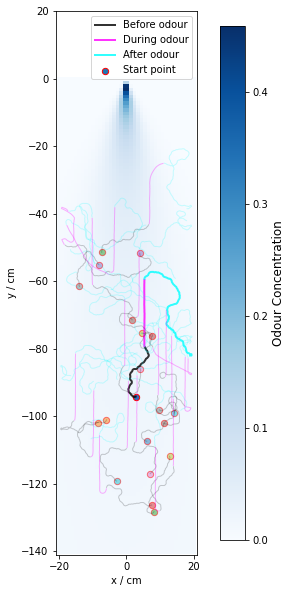

In [50]:
# plot result
fig, ax = plt.subplots(figsize=(10,10))

# odour concentration
heatmap = ax.pcolormesh(mesh_x, mesh_y, mesh_c, cmap='Blues', shading='auto')

selected_id = 3

pos = pos_s[selected_id]
 # start point
ax.scatter(pos[0,0],pos[0,1], s=40, marker='o', c=None, edgecolor='red', label='Start point')
ax.plot(pos[:odour_on_period[0],0],pos[:odour_on_period[0],1],c='black',lw=2.0, alpha=0.8, label='Before odour')
ax.plot(pos[odour_on_period[0]:odour_on_period[1],0],pos[odour_on_period[0]:odour_on_period[1],1],
        alpha=0.8, c='magenta',lw=2.0,label='During odour')
ax.plot(pos[odour_on_period[1]:,0],pos[odour_on_period[1]:,1],
        alpha=0.8, c='cyan',lw=2.0, label='After odour')


for i, pos in enumerate(pos_s):
    if i!=selected_id:
        # start point
        ax.scatter(pos[0,0],pos[0,1],s=40, marker='o', c=None, edgecolor='red', alpha=0.5)
        # trajectory
        ax.plot(pos[:odour_on_period[0],0],pos[:odour_on_period[0],1],c='black',lw=1.0, alpha=0.2)
        ax.plot(pos[odour_on_period[0]:odour_on_period[1],0],pos[odour_on_period[0]:odour_on_period[1],1],
                alpha=0.3, c='magenta',lw=1.0)
        ax.plot(pos[odour_on_period[1]:,0],pos[odour_on_period[1]:,1],
                alpha=0.2, c='cyan',lw=1.0)

# add colorar
colorbar = fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
colorbar.set_label('Odour Concentration', fontsize=12)


ax.set_xlim(-21,21)
ax.set_ylim(-141,20)
ax.set_xlabel('x / cm')
ax.set_ylabel('y / cm')
ax.set_aspect(1)

ax.legend()

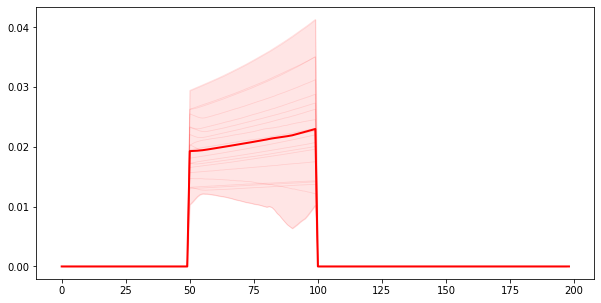

In [31]:
# plot result
fig, ax = plt.subplots(figsize=(10,5))

# ax.plot(odor_s[selected_id][:-1])
for i, odor_c in enumerate(odor_s):
    ax.plot(odor_c[:-1], c='red', alpha=0.1, lw=0.8)

ax.plot(np.mean(np.array(odor_s)[:,:-1], axis=0), color='red',lw=2)
ax.fill_between(np.arange(0,min(t_s)), np.max(np.array(odor_s)[:,:min(t_s)], axis=0), np.min(np.array(odor_s)[:,:min(t_s)], axis=0),
                  color='r', alpha=0.1)

In [52]:
sio.savemat('results/integrated.mat',{'pos':pos_s, 'h':h_s, 'v':v_s, 'odor':odor_s, 'dis':dis_s, 't_s':t_s, 'response_state':response_state,
                                      'mesh_x':mesh_x, 'mesh_y':mesh_y, 'mesh_c':mesh_c, 
                                      'odour_daynamics': odour_on_period, 'odour_input':odour_input,
                                      'step_size':step_size, 'motor_k':motor_k, 'time_out':time_out})

## Ants - integrated with PI

In [34]:
from odor_wind_navigation import OdourWindNavigationAnt

# odour source param
sx = 0
sy = 0
q = 20
u = 10
w_dir = np.pi
pi_initial_memory = 0.1
radius = 4
OwN_ant = OdourWindNavigationAnt(pi_initial_memory, q, u, w_dir, radius, sx, sy)

In [35]:
# get the concentration heatmap of the odour
x = np.linspace(-4, 0, 40)
y = np.linspace(-5, 2, 70)
mesh_x, mesh_y = np.meshgrid(x, y)

mesh_c = OwN_ant.odour_field.get_odour_concentration(mesh_x, mesh_y)

In [10]:
# generate the PI memory
pi_len = 11.0 # m
pi_dir = -90 # deg

# run a trial
start_pos1 = np.array([-1.0,-10.0])
start_pos2 = np.array([1.5,-10.0])
start_h = np.pi/2

step_size = 0.05 #　m
motor_k = 2.0

pi_initial_memory = 0.2
pi_memory = OwN_ant.generate_pi_memory(pi_len, pi_dir, step_size, pi_initial_memory)

time_out = 250
w_dir = np.pi * np.ones(time_out)

OwN_ant.odour_on_thr = 2.5
OwN_ant.odour_tune_k = 2.0
OwN_ant.cpu4_mem_gain = 0.10
t, odor, pos, h, velocity, pi_memory, ra_memory, s, dis= OwN_ant.run(start_pos1, start_h, time_out, w_dir, motor_k=motor_k, step_size=step_size, 
                                                                     odour_strategy='integrated_odour', with_pi=True)

$-Start homing...


E:\Python37-w64\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


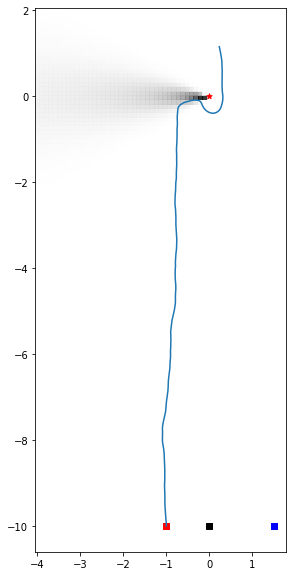

In [11]:
fig,ax=plt.subplots(figsize=(5,10))
ax.pcolormesh(mesh_x, mesh_y, mesh_c, alpha=0.8, cmap='gray_r', shading='auto')
# feeder
ax.scatter(0,-10,marker='s',c='black',s=30)
# nest
ax.scatter(0,0,marker='*',c='red',s=30)
# RP1
ax.scatter(start_pos1[0],start_pos1[1],marker='s',c='red',s=30)
# RP2
ax.scatter(start_pos2[0],start_pos2[1],marker='s',c='blue',s=30)

# homing route
ax.plot(pos[:,0],pos[:,1])

ax.set_aspect(1)

In [50]:
%%time
# run trials
# generate the PI memory
pi_len = 10.0 # m
pi_dir = -90 # deg

# run a trial
start_pos1 = np.array([-1.5,-10.0])
start_pos2 = np.array([1.5,-10.0])
start_pos_s = [start_pos1, start_pos2]
# start_pos_s = [[0, -10.0]]
start_h_s = np.linspace(-np.pi, np.pi, 10, endpoint=False)

step_size = 0.05 #　m
motor_k = 1.0

pi_initial_memory = 0.2


time_out = 280
w_dir = np.pi * np.ones(time_out)

OwN_ant.odour_on_thr = 1.2
OwN_ant.on_response_thr = 0.5
OwN_ant.odour_tune_k = 0.1
OwN_ant.cpu4_mem_gain = 0.10
pos_s = []
h_s = []
odor_s = []
dis_s = []
t_s = []
v_s = []
pi_memory_s = []
ra_memory_s = []
response_state = []

# start trial
for sp in start_pos_s:
    for sh in start_h_s:
        print('start at [%.1f,%.1f] with heading %.1fdeg'%(sp[0], sp[1], sh/np.pi*180))
        # rebuild PI memory
        pi_memory = OwN_ant.generate_pi_memory(pi_len, pi_dir, step_size, pi_initial_memory)
        t, odor, pos, h, velocity, pi_memory, ra_memory, s, dis = OwN_ant.run(sp, sh, time_out, w_dir, motor_k=motor_k, step_size=step_size, 
                                                                              odour_strategy='integrated_odour', with_pi=True)
        pos_s.append(pos)
        v_s.append(velocity)
        h_s.append(h)
        odor_s.append(odor)
        dis_s.append(dis)
        t_s.append(t)
        response_state.append(s)
        pi_memory_s.append(pi_memory)
        ra_memory_s.append(ra_memory)

start at [-1.5,-10.0] with heading -180.0deg
$-Start homing...


E:\Python37-w64\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


$-End homing with nest distance 0.11 m
start at [-1.5,-10.0] with heading -144.0deg
$-Start homing...
$-End homing with nest distance 0.13 m
start at [-1.5,-10.0] with heading -108.0deg
$-Start homing...
start at [-1.5,-10.0] with heading -72.0deg
$-Start homing...
start at [-1.5,-10.0] with heading -36.0deg
$-Start homing...
start at [-1.5,-10.0] with heading 0.0deg
$-Start homing...
start at [-1.5,-10.0] with heading 36.0deg
$-Start homing...
start at [-1.5,-10.0] with heading 72.0deg
$-Start homing...
$-End homing with nest distance 0.13 m
start at [-1.5,-10.0] with heading 108.0deg
$-Start homing...
$-End homing with nest distance 0.10 m
start at [-1.5,-10.0] with heading 144.0deg
$-Start homing...
$-End homing with nest distance 0.14 m
start at [1.5,-10.0] with heading -180.0deg
$-Start homing...
start at [1.5,-10.0] with heading -144.0deg
$-Start homing...
start at [1.5,-10.0] with heading -108.0deg
$-Start homing...
start at [1.5,-10.0] with heading -72.0deg
$-Start homing...
st

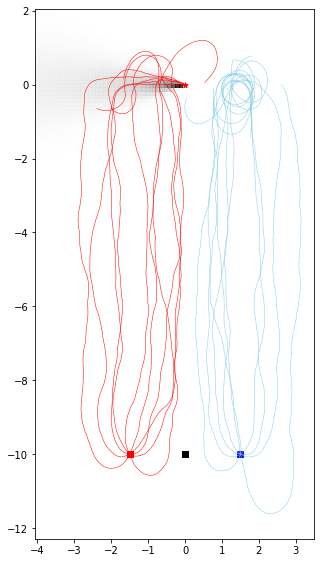

In [51]:
# plot the results to check
fig,ax=plt.subplots(figsize=(5,10))
ax.pcolormesh(mesh_x, mesh_y, mesh_c, alpha=0.8, cmap='gray_r', shading='auto')
# feeder
ax.scatter(0,-10,marker='s',c='black',s=30)
# nest
ax.scatter(0,0,marker='*',c='red',s=30)
# RP1
ax.scatter(start_pos1[0],start_pos1[1],marker='s',c='red',s=30)
# RP2
ax.scatter(start_pos2[0],start_pos2[1],marker='s',c='blue',s=30)

# homing route
for i, pos in enumerate(pos_s):
    lc = 'red' if i < len(pos_s)/2 else 'skyblue'
    ax.plot(pos[:,0],pos[:,1], c=lc, lw=0.5)

ax.set_aspect(1)

In [107]:
# save data
sio.savemat('results/ants_integrated.mat',{'pos':pos_s, 'h':h_s, 'v':v_s, 'odor':odor_s, 'dis':dis_s, 't_s':t_s, 'response_state':response_state,
                                           'mesh_x':mesh_x, 'mesh_y':mesh_y, 'mesh_c':mesh_c, 'pi_memory':pi_memory_s, 'ra_memory': ra_memory_s,
                                           'step_size':step_size, 'motor_k':motor_k, 'time_out':time_out})

e:\program files\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


additional odour field

In [52]:
from odor_wind_navigation import OdourWindNavigationAnt

# odour source param
sx = 0
sy = 0
q = 20
u = 10
w_dir = np.pi
pi_initial_memory = 0.1
radius = 4
additional_odour = {'sx':0, 'sy':-9, 'q':q, 'u':u}
OwN_ant = OdourWindNavigationAnt(pi_initial_memory, q, u, w_dir, radius, sx, sy,
                                 additional_odour=additional_odour)

In [53]:
# get the concentration heatmap of the odour
x = np.linspace(-4, 0, 40)
y = np.linspace(-5, 2, 70)
mesh_x, mesh_y = np.meshgrid(x, y)
mesh_c = OwN_ant.odour_field.get_odour_concentration(mesh_x, mesh_y)
if OwN_ant.odour_field_add is not None:
    x_add = np.linspace(-4, 0, 40)
    y_add = np.linspace(-10, -3, 70)
    mesh_x_add, mesh_y_add = np.meshgrid(x_add, y_add)
    mesh_c_add = OwN_ant.odour_field_add.get_odour_concentration(mesh_x_add, mesh_y_add)

In [60]:
# generate the PI memory
pi_len = 10.0 # m
pi_dir = -90 # deg

# run a trial
start_pos1 = np.array([-1.0,-10.0])
start_pos2 = np.array([1.5,-10.0])
start_h = np.pi
step_size = 0.05 #　m
motor_k = 1.0

pi_initial_memory = 0.2
pi_memory = OwN_ant.generate_pi_memory(pi_len, pi_dir, step_size, pi_initial_memory)

time_out = 300
w_dir = np.pi * np.ones(time_out)

OwN_ant.odour_on_thr = 1.2
OwN_ant.on_response_thr = 0.5
OwN_ant.odour_tune_k = 0.5
OwN_ant.cpu4_mem_gain = 0.10

t, odor, pos, h, velocity, pi_memory, ra_memory, s, dis= OwN_ant.run(start_pos1, start_h, time_out, w_dir, motor_k=motor_k, step_size=step_size, 
                                                                     odour_strategy='integrated_odour', with_pi=True)

$-Start homing...


E:\Python37-w64\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


$-End homing with nest distance 0.12 m


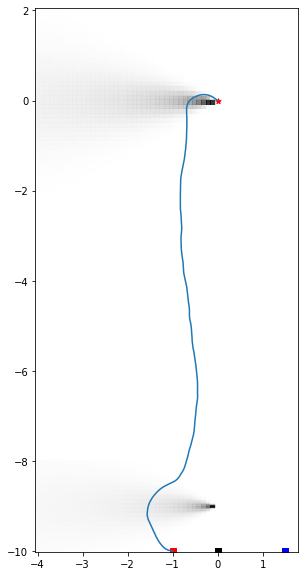

In [61]:
fig,ax=plt.subplots(figsize=(5,10))
ax.pcolormesh(mesh_x, mesh_y, mesh_c, alpha=0.8, cmap='gray_r', shading='auto')
ax.pcolormesh(mesh_x_add, mesh_y_add, mesh_c_add, alpha=0.8, cmap='gray_r', shading='auto')
# feeder
ax.scatter(0,-10,marker='s',c='black',s=30)
# nest
ax.scatter(0,0,marker='*',c='red',s=30)
# RP1
ax.scatter(start_pos1[0],start_pos1[1],marker='s',c='red',s=30)
# RP2
ax.scatter(start_pos2[0],start_pos2[1],marker='s',c='blue',s=30)

# homing route
ax.plot(pos[:,0],pos[:,1])

ax.set_aspect(1)

In [62]:
%%time
# run trials
# generate the PI memory
pi_len = 10.0 # m
pi_dir = -90 # deg

# run a trial
start_pos1 = np.array([-1.5,-10.0])
start_pos2 = np.array([1.5,-10.0])
start_pos_s = [start_pos1, start_pos2]
# start_pos_s = [[0, -10.0]]
start_h_s = np.linspace(-np.pi, np.pi, 10, endpoint=False)

step_size = 0.05 #　m
motor_k = 1.0

pi_initial_memory = 0.2


time_out = 300
w_dir = np.pi * np.ones(time_out)

OwN_ant.odour_on_thr = 1.2
OwN_ant.on_response_thr = 0.5
OwN_ant.odour_tune_k = 0.5
OwN_ant.cpu4_mem_gain = 0.10
pos_s = []
h_s = []
odor_s = []
dis_s = []
t_s = []
v_s = []
pi_memory_s = []
ra_memory_s = []
response_state = []

# start trial
for sp in start_pos_s:
    for sh in start_h_s:
        print('start at [%.1f,%.1f] with heading %.1fdeg'%(sp[0], sp[1], sh/np.pi*180))
        # rebuild PI memory
        pi_memory = OwN_ant.generate_pi_memory(pi_len, pi_dir, step_size, pi_initial_memory)
        t, odor, pos, h, velocity, pi_memory, ra_memory, s, dis = OwN_ant.run(sp, sh, time_out, w_dir, motor_k=motor_k, step_size=step_size, 
                                                                              odour_strategy='integrated_odour', with_pi=True)
        pos_s.append(pos)
        v_s.append(velocity)
        h_s.append(h)
        odor_s.append(odor)
        dis_s.append(dis)
        t_s.append(t)
        response_state.append(s)
        pi_memory_s.append(pi_memory)
        ra_memory_s.append(ra_memory)

start at [-1.5,-10.0] with heading -180.0deg
$-Start homing...


E:\Python37-w64\lib\site-packages\numpy\core\fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


$-End homing with nest distance 0.12 m
start at [-1.5,-10.0] with heading -144.0deg
$-Start homing...
$-End homing with nest distance 0.13 m
start at [-1.5,-10.0] with heading -108.0deg
$-Start homing...
$-End homing with nest distance 0.12 m
start at [-1.5,-10.0] with heading -72.0deg
$-Start homing...
$-End homing with nest distance 0.13 m
start at [-1.5,-10.0] with heading -36.0deg
$-Start homing...
$-End homing with nest distance 0.11 m
start at [-1.5,-10.0] with heading 0.0deg
$-Start homing...
$-End homing with nest distance 0.13 m
start at [-1.5,-10.0] with heading 36.0deg
$-Start homing...
$-End homing with nest distance 0.14 m
start at [-1.5,-10.0] with heading 72.0deg
$-Start homing...
$-End homing with nest distance 0.13 m
start at [-1.5,-10.0] with heading 108.0deg
$-Start homing...
$-End homing with nest distance 0.14 m
start at [-1.5,-10.0] with heading 144.0deg
$-Start homing...
start at [1.5,-10.0] with heading -180.0deg
$-Start homing...
start at [1.5,-10.0] with headi

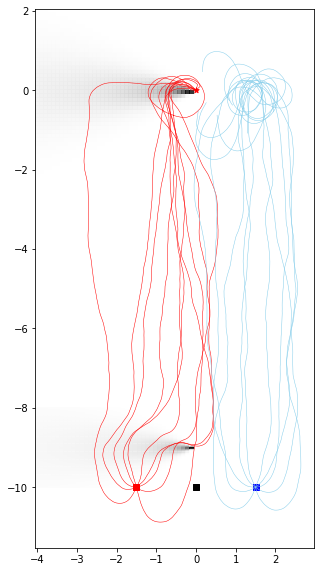

In [63]:
# plot the results to check
fig,ax=plt.subplots(figsize=(5,10))
ax.pcolormesh(mesh_x, mesh_y, mesh_c, alpha=0.8, cmap='gray_r', shading='auto')
ax.pcolormesh(mesh_x_add, mesh_y_add, mesh_c_add, alpha=0.8, cmap='gray_r', shading='auto')
# feeder
ax.scatter(0,-10,marker='s',c='black',s=30)
# nest
ax.scatter(0,0,marker='*',c='red',s=30)
# RP1
ax.scatter(start_pos1[0],start_pos1[1],marker='s',c='red',s=30)
# RP2
ax.scatter(start_pos2[0],start_pos2[1],marker='s',c='blue',s=30)

# homing route
for i, pos in enumerate(pos_s):
    lc = 'red' if i < len(pos_s)/2 else 'skyblue'
    ax.plot(pos[:,0],pos[:,1], c=lc, lw=0.5)

ax.set_aspect(1)

In [29]:
# save data
sio.savemat('results/ants_integrated_add_odour_t300.mat',{'pos':pos_s, 'h':h_s, 'v':v_s, 'odor':odor_s, 'dis':dis_s, 't_s':t_s, 'response_state':response_state, 'mesh_x':mesh_x, 'mesh_y':mesh_y, 'mesh_c':mesh_c, 'mesh_x_add':mesh_x_add, 'mesh_y_add':mesh_y_add, 'mesh_c_add':mesh_c_add, 'pi_memory':pi_memory_s, 'ra_memory': ra_memory_s, 'step_size':step_size, 'motor_k':motor_k, 'time_out':time_out})

E:\Python37-w64\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## flying flies

In [163]:
from odor_wind_navigation import OdourWindNavigationFly

# odour source param
sx = None
sy = 0.12
q = 10
# with no wind affect the odour field
u = 0
w_dir = np.pi

radius = 0.02

OwN_fly = OdourWindNavigationFly(q, u, w_dir, radius, sx, sy, shape='bar')

In [198]:
# get the concentration heatmap of the odour
x = np.linspace(0, 1.5, 150)
y = np.linspace(0, 0.3, 150)
mesh_x, mesh_y = np.meshgrid(x, y)

mesh_c = OwN_fly.odour_field.get_odour_concentration(mesh_x, mesh_y)

In [243]:
### run serials of trials
from odor_wind_navigation import OdourWindNavigationFly
# odour source param
sx = None
sy = 0.15
q = 10
# with no wind affect the odour field
u = 0
w_dir = np.pi
radius = 0.01

agent_num = 2
# create agent
agents = list([OdourWindNavigationFly(q, u, w_dir, radius, sx, sy, shape='bar', handedness=i%2) for i in range(agent_num)])

# get the concentration heatmap of the odour
x = np.linspace(0, 1.5, 150)
y = np.linspace(0, 0.3, 150)
mesh_x, mesh_y = np.meshgrid(x, y)

mesh_c = agents[0].odour_field.get_odour_concentration(mesh_x, mesh_y)

trial_num = 2

time_out = 300
step_size = 0.005
motor_k = 1.5

wind_direction = np.pi * np.ones(time_out)

# store the data
pos_s = []
h_s = []
odor_s = []
dis_s = []
t_s = []
v_s = []
response_state = []
# generate odour dynamics
# odour_on_period = [int(time_out/4), int(time_out/2)]
# odour_input = np.zeros(time_out)
# odour_input[odour_on_period[0]:odour_on_period[1]] = 1.0
odour_input = np.ones(time_out)
# arena boundary
arena_boundary = [0, 1.5, 0, 0.3]
# odour region (ribbon plume)
# odour_region = [0, 1.3, 0.12, 0.13]
for i, agent in enumerate(agents):
    for trial in range(trial_num):
        print('%dth agent - %dth trial -> %s:' % (i, trial, 'integrated'))
        agent.odour_on_thr = 6.0
        
        agent.on_response_thr = 1e-3
        agent.off_response_thr = -1e-3
        
        agent.collision_thr = step_size
        # x in [0,0.25], y in [0,0.3]
#         start_pos = [0.25*(np.random.rand(1)), np.random.rand(1)*0.2]
        start_pos = [0.1, 0.2]
        start_h = np.random.rand(1)*np.pi*2
        pos, h, v, odor, dis, t = agent.run(start_pos, start_h, time_out,
                                            odour_input, wind_direction, strategy='integrated', oh_k=10,
                                            step_size=step_size, motor_k=motor_k, stop_by_source=False, boundary=arena_boundary,
                                            constant_odour=False)
        pos_s.append(pos)
        v_s.append(v)
        h_s.append(h)
        odor_s.append(odor)
        dis_s.append(dis)
        t_s.append(t)
        response_state.append(agent.response_state)

0th agent - 0th trial -> integrated:
0th agent - 1th trial -> integrated:
1th agent - 0th trial -> integrated:
1th agent - 1th trial -> integrated:


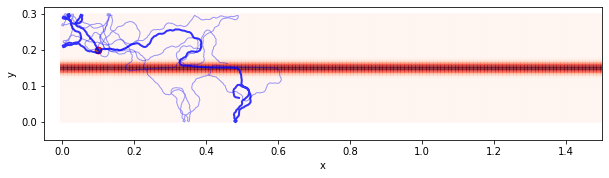

In [244]:
# plot result
fig, ax = plt.subplots(figsize=(10,10))

# odour concentration
heatmap = ax.pcolormesh(mesh_x, mesh_y, mesh_c, cmap='Reds', shading='auto', alpha=0.5)

# tri_pi1 = plt.Polygon([[0,0.13],[0,0.12],[1.3,0.12],[1.3,0.13]], color='orange',label='PI dircetion')

# ax.add_patch(tri_pi1)

selected_id = 0

pos = pos_s[selected_id]
 # start point
ax.scatter(pos[0,0],pos[0,1], s=40, marker='o', c=None, edgecolor='red', label='Start point')
# ax.plot(pos[:odour_on_period[0],0],pos[:odour_on_period[0],1],c='black',lw=2.0, alpha=0.8, label='Before odour')
# ax.plot(pos[odour_on_period[0]:odour_on_period[1],0],pos[odour_on_period[0]:odour_on_period[1],1],
#         alpha=0.8, c='magenta',lw=2.0,label='During odour')
# ax.plot(pos[odour_on_period[1]:,0],pos[odour_on_period[1]:,1],
#         alpha=0.8, c='cyan',lw=2.0, label='After odour')
ax.plot(pos[:,0],pos[:,1], alpha=0.8, c='blue',lw=2.0, label='After odour')

for i, pos in enumerate(pos_s):
    if i!=selected_id:
        # start point
        ax.scatter(pos[0,0],pos[0,1],s=40, marker='o', c=None, edgecolor='red', alpha=0.5)
        # trajectory
#         ax.plot(pos[:odour_on_period[0],0],pos[:odour_on_period[0],1],c='black',lw=1.0, alpha=0.2)
#         ax.plot(pos[odour_on_period[0]:odour_on_period[1],0],pos[odour_on_period[0]:odour_on_period[1],1],
#                 alpha=0.3, c='magenta',lw=1.0)
#         ax.plot(pos[odour_on_period[1]:,0],pos[odour_on_period[1]:,1],
#                 alpha=0.2, c='cyan',lw=1.0)
        ax.plot(pos[:,0],pos[:,1], alpha=0.4, c='blue',lw=1.0, label='After odour')

# add colorar
# colorbar = fig.colorbar(heatmap, ax=ax, fraction=0.046, pad=0.04)
# colorbar.set_label('Odour Concentration', fontsize=12)


ax.set_xlim(-0.05,1.5)
ax.set_ylim(-0.05,0.32)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect(1)

# ax.legend()

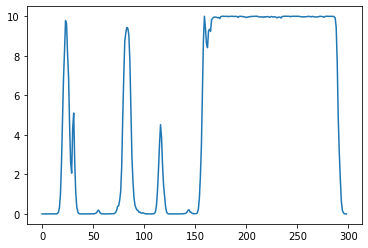

In [241]:
plt.plot(odor_s[selected_id][:-1])

In [228]:
response_state[selected_id]

['Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'ON response',
 'ON response',
 'ON response',
 'ON response',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'ON response',
 'ON response',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'Random',
 'ON response',
 'Random',
 'Random',
 'Random',
 'Random

In [188]:
pos, h, v, odor, dis, t = agent.run([0,0.2], start_h, 150,
                                    odour_input, wind_direction, strategy='integrated', oh_k=0.1,
                                    step_size=step_size, motor_k=motor_k, stop_by_source=False, boundary=arena_boundary,
                                    constant_odour=False)

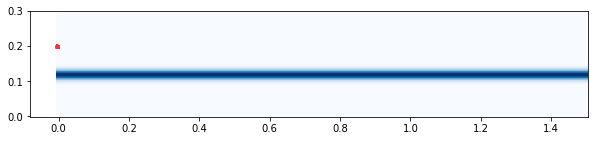

In [189]:
# odour concentration
# plot result
fig, ax = plt.subplots(figsize=(10,10))
heatmap = ax.pcolormesh(mesh_x, mesh_y, mesh_c, cmap='Blues', shading='auto')
ax.plot(pos[:,0],pos[:,1], alpha=0.8, c='red',lw=2.0, label='After odour')
ax.set_aspect(1)

+ shift reference

In [63]:
from odor_wind_navigation import ShiftReferences
from insect_brain_model import WindDirectionEncoder

    + wind compensation

In [114]:
agent = ShiftReferences()
# parameters
agent.random_motor_w = 0.1
# wind encoding
wind_encoder = WindDirectionEncoder()
# shift 90deg

trial_num = 20
heading_before_wind = np.pi/2
heading_after_wind = np.random.randn(trial_num) * np.pi
pos_s = []
h_s = []

time_out = 100
# wind dirction, 0 for eastward, and np.pi for westward
wind_direction = 0
# generate desired heading when clutching
# get WPN encoding the wind direction
wpn = wind_encoder.upwind_activation(heading_before_wind,
                                     wind_direction)
# get desired heading by shifting acoording to the WPN activation
agent.update_desired_headings(heading_before_wind, wpn)
for i in range(trial_num):
    # after being blown away
    t,pos,h,v = agent.run([0,0], heading_after_wind[i], time_out)
    pos_s.append(pos)
    h_s.append(h)
pos_s = np.array(pos_s)
h_s = np.array(h_s)

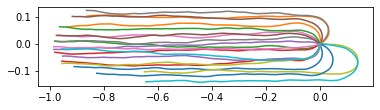

In [115]:
# show the data
for i in range(trial_num):
    plt.plot(pos_s[i][:,0], pos_s[i][:,1])
ax=plt.gca()
ax.set_aspect(1)

In [110]:
# save the data
sio.savemat('results/WindCompensating_EastwardWind.mat',{'pos':pos_s, 'h':h_s})

    + backtracking

In [111]:
agent = ShiftReferences()
# parameters
agent.random_motor_w = 0.2
# shift 90deg
agent.update_desired_headings(np.pi/2, 4)
trial_num = 20
start_h = np.random.randn(trial_num) * np.pi
pos_s = []
h_s = []

time_out = 100
for sh in start_h:
    t,pos,h,v = agent.run([0,0], sh, time_out)
    pos_s.append(pos)
    h_s.append(h)
pos_s = np.array(pos_s)
h_s = np.array(h_s)

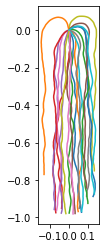

In [112]:
for i in range(trial_num):
    plt.plot(pos_s[i][:,0], pos_s[i][:,1])
ax=plt.gca()
ax.set_aspect(1)

In [113]:
# save the simulational data
sio.savemat('results/Backtracking.mat',{'pos':pos_s, 'h':h_s})